<a href="https://colab.research.google.com/github/pgmcdonald/cautious-spork/blob/main/convert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Steps 
1. Upload XML file into the /content folder. 

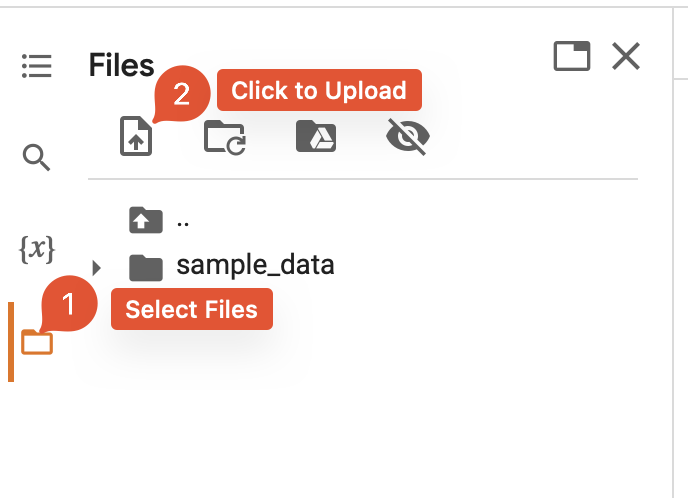
2. Update the variable XML_FILE_NAME on Line #9 of the XML file named uploaded.

3. Download diss_from_xml_export.xlsx after running code




In [ ]:
!pip install xmltodict pandas xlsxwriter

In [ ]:
import sys
import os
import datetime
import xmltodict
import pandas as pd
import getopt

#UPDATE THIS FILE NAME BEFORE RUNNING
XML_FILE_NAME= 'CombineXML.xml'

def main():

    now = datetime.datetime.now()
    run_dt = now.strftime("%Y%m%d")
    
    #List of Dictionsary
    dictList=[]
    
    with open(XML_FILE_NAME) as fd:
        doc = xmltodict.parse(fd.read())
    
    for item in doc['root']['DISS_submission']:
        data_dict={}
        diss_Title = item['DISS_description']['DISS_title']
        diss_FullText_Url = ""
        diss_Binary= item['DISS_content']['DISS_binary']['#text']
        diss_Keyword = item['DISS_description']['DISS_categorization']['DISS_keyword']
        diss_Abstract= item['DISS_content']['DISS_abstract']['DISS_para']
        diss_FName=item['DISS_authorship']['DISS_author']['DISS_name']['DISS_fname']
        diss_Middle=item['DISS_authorship']['DISS_author']['DISS_name']['DISS_middle']
        diss_SurName=item['DISS_authorship']['DISS_author']['DISS_name']['DISS_surname']
        diss_Suffix=item['DISS_authorship']['DISS_author']['DISS_name']['DISS_suffix']
    
        if(isinstance(item['DISS_authorship']['DISS_author']['DISS_contact'], dict)):
            diss_Email=item['DISS_authorship']['DISS_author']['DISS_contact']['DISS_email']
        #if there are many emails pick the "future" email over current. 
        else:
            for contacts in item['DISS_authorship']['DISS_author']['DISS_contact']:
                if contacts['@type'] == 'future':
                  diss_Email=contacts['DISS_email']
    

        diss_Institution= item['DISS_description']['DISS_institution']['DISS_inst_name']

        advisor_list = ["", "", ""]
        index=0
        if(isinstance(item['DISS_description']['DISS_advisor'], dict)):
            diss_Advisor_fname=item['DISS_description']['DISS_advisor']['DISS_name']['DISS_fname']
            diss_Surname=item['DISS_description']['DISS_advisor']['DISS_name']['DISS_surname']
            diss_Advisor_name = diss_Advisor_fname+" "+diss_Surname
            advisor_list.insert(index,diss_Advisor_name)
        else:
            for advisor in item['DISS_description']['DISS_advisor']:
                diss_Advisor_fname=advisor['DISS_name']['DISS_fname']
                diss_Surname=advisor['DISS_name']['DISS_surname']
                diss_Advisor_name = diss_Advisor_fname+" "+diss_Surname
                advisor_list.insert(index,diss_Advisor_name)
                index = index + 1

        #diss_Advisor_fname=item['DISS_description']['DISS_advisor']['DISS_name']['DISS_fname']


        diss_Degree= item['DISS_description']['DISS_degree']
        diss_Contact= item['DISS_description']['DISS_institution']['DISS_inst_contact']
        diss_Type= item['DISS_description']['@type']
        diss_Binary_Type= item['DISS_content']['DISS_binary']['@type']
        diss_Language = item['DISS_description']['DISS_categorization']['DISS_language']
        diss_AwardDate = item['DISS_description']['DISS_dates']['DISS_comp_date']
        diss_disciplines  = []
        if(isinstance(item['DISS_description']['DISS_categorization']['DISS_category'], dict)):
            diss_disciplines.append(item['DISS_description']['DISS_categorization']['DISS_category']['DISS_cat_desc'])
        else:
            for category in item['DISS_description']['DISS_categorization']['DISS_category']:
                diss_disciplines.append(category['DISS_cat_desc']) 
            diss_disciplines = ','.join(diss_disciplines)
        

        data_dict={  'title': diss_Title, 
                     'fulltext_url': diss_FullText_Url, 
                     'filename': diss_Binary,
                     'keywords': diss_Keyword,
                     'abstract': diss_Abstract,
                     'author1_fname':diss_FName,
                     'author1_mname':diss_Middle,
                     'author1_lname':diss_SurName,
                     'author1_suffix':diss_Suffix,
                     'author1_email': diss_Email,
                     'author1_institution':diss_Institution,
                     'advisor1':advisor_list[0],
                     'advisor2':advisor_list[1],
                     'advisor3':advisor_list[2],
                     'award_date':diss_AwardDate,
                     'disciplines':diss_disciplines,
                     'comments':"",
                     'copyright_date':"",
                     'degree_name':diss_Degree,
                     'department':diss_Contact,
                     'document_type':diss_Type,
                     'downloads_prior':"",
                     'embargo_date':"",
                     'fileformat':diss_Binary_Type,
                     'file_size':"",
                     'geolocate':"",
                     'language':diss_Language,
                     'latitude':"",
                     'longitude':"",
                     'provenance':"",
                     'publication_date':"",
                     'season':"",
                     'publication_date_date_format':"",
                     'rights_holder':"",
                   }
    
        dictList.append(data_dict)
        #Debug the Python DIctionary
        #Prints each Key:Value
        #for key, value in data_dict.items():
        #    print(key, ' : ', value)
    
    df=pd.DataFrame(dictList)
    #Print final Dataframe we are writting to Excel. 
    #print(df)

    #EXCEL magic
    filename = "diss_from_xml_export.xlsx".format(run_dt)

    
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    df.to_excel(writer, sheet_name='Export', startrow=1, header=False, index=False)


    # Get the xlsxwriter workbook and worksheet objects.
    workbook = writer.book
    worksheet = writer.sheets['Export']

    # Get the dimensions of the dataframe.
    (max_row, max_col) = df.shape

    # Create a list of column headers, to use in add_table().\
    column_settings = [{'header': column} for column in df.columns]

    # Add the Excel table structure. Pandas will add the data.
    worksheet.add_table(0, 0, max_row, max_col - 1, {'columns': column_settings, 'style': 'Table Style Medium 1'})   

    # Make the columns wider for clarity.
    worksheet.set_column(0, max_col - 1, 20) 

    # Close the Pandas Excel writer and output the Excel file.
    writer.close()

    print("*****   Processing is complete   *****")
    print("File Generated:", filename)
main()


*****   Processing is complete   *****
File Generated: diss_from_xml_export.xlsx
